In [1]:
#Library Imports

from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import warnings
from sklearn.cluster import KMeans
import wrds
import pandas_ta as ta

# Importing Data

In [2]:
#Connecting to WRDS

conn=wrds.Connection()

Loading library list...
Done


In [3]:
sp500 = conn.raw_sql("""
                        select a.*, b.date, b.ret
                        from crsp.msp500list as a,
                        crsp.dsf as b
                        where a.permno=b.permno
                        and b.date >= a.start and b.date<= a.ending
                        and b.date>='01/01/2009'
                        order by b.date;
                        """, date_cols=['start', 'ending', 'date'])

In [4]:
#Add Other Descriptive Variables

mse = conn.raw_sql("""
                        select comnam, ncusip, namedt, nameendt,
                        permno, shrcd, exchcd, hsiccd, ticker
                        from crsp.msenames
                        """, date_cols=['namedt', 'nameendt'])

#if nameendt is missing then set to today date
mse['nameendt']=mse['nameendt'].fillna(pd.to_datetime('today'))

In [5]:
#Merge with SP500 data
sp500_full = pd.merge(sp500, mse, how = 'left', on = 'permno')

#Impose the date range restrictions
sp500_full = sp500_full.loc[(sp500_full.date>=sp500_full.namedt) \
                            & (sp500_full.date<=sp500_full.nameendt)]
sp500_full.sample(5)

,permno,start,ending,date,ret,comnam,ncusip,namedt,nameendt,shrcd,exchcd,hsiccd,ticker
12920209,12308,2016-09-08,2024-12-31,2022-07-01,0.026444,CHARTER COMMUNICATIONS INC NEW,16119P10,2020-02-25,2023-04-02,11,3,4841,CHTR
8542378,84373,2002-12-12,2024-12-31,2017-11-03,0.003627,QUEST DIAGNOSTICS INC,74834L10,2004-06-10,2024-12-31,11,1,8071,DGX
9501504,76076,1993-12-31,2024-12-31,2018-11-02,-0.003724,CISCO SYSTEMS INC,17275R10,2014-02-13,2024-12-31,11,3,3674,CSCO
1322215,29946,1982-10-14,2024-12-31,2010-05-12,0.022751,BROWN FORMAN CORP,11563720,2004-07-27,2014-01-07,11,1,2085,BF
6619024,91556,2009-12-21,2024-12-31,2015-10-30,0.007971,ROSS STORES INC,77829610,2006-06-30,2016-08-18,11,3,5650,ROST


In [6]:
#Linking with Compustat through CCM

ccm=conn.raw_sql("""
                  select gvkey, liid as iid, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

#if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

In [7]:
#Merge the CCM data with S&P500 data
#First just link by matching PERMNO
sp500ccm = pd.merge(sp500_full, ccm, how='left', on=['permno'])

#Then set link date bounds
sp500ccm = sp500ccm.loc[(sp500ccm['date']>=sp500ccm['linkdt'])\
                        &(sp500ccm['date']<=sp500ccm['linkenddt'])]
sp500ccm.sample(5)

,permno,start,ending,date,ret,comnam,ncusip,namedt,nameendt,shrcd,exchcd,hsiccd,ticker,gvkey,iid,linktype,linkprim,linkdt,linkenddt
941839,10299,2000-04-03,2017-03-10,2014-12-23,-0.005994,LINEAR TECHNOLOGY CORP,53567810,2004-06-10,2017-03-10,11,3,3670,LLTC,012216,01,LU,P,1986-05-28,2017-03-31 00:00:00.000000
1859720,24109,1951-09-06,2024-12-31,2020-11-20,0.000485,AMERICAN ELECTRIC POWER CO INC,02553710,2020-10-01,2024-12-31,11,3,4911,AEP,001440,01,LC,P,1962-01-31,2025-04-24 22:24:31.824863
460712,38682,1984-07-19,2012-12-11,2011-11-22,-0.009729,DONNELLEY R R & SONS CO,25786710,2009-08-05,2016-08-21,11,3,2754,RRD,004040,01,LC,P,1962-12-07,2022-02-28 00:00:00.000000
1057403,89258,2002-07-22,2024-12-31,2015-09-23,0.005143,PRUDENTIAL FINANCIAL INC,74432010,2004-06-10,2021-02-28,11,1,6311,PRU,143356,01,LC,P,2001-12-13,2025-04-24 22:24:31.824863
1344834,15069,1925-12-31,2024-11-25,2017-07-27,0.004105,MARATHON OIL CORP,56584910,2016-12-22,2021-03-31,11,1,1311,MRO,007017,01,LC,C,1991-04-12,2025-04-24 22:24:31.824863


In [8]:
#Rearrange columns for final output

sp500ccm = sp500ccm.drop(columns=['namedt', 'nameendt', \
                                  'linktype', 'linkprim', 'linkdt', 'linkenddt'])
sp500ccm = sp500ccm[['date', 'permno', 'comnam', 'ncusip', 'shrcd', 'exchcd', 'hsiccd', 'ticker', \
                     'gvkey', 'iid', 'start', 'ending', 'ret']]
sp500ccm.sample(5)

,date,permno,comnam,ncusip,shrcd,exchcd,hsiccd,ticker,gvkey,iid,start,ending,ret
1377670,2017-10-11,23536,W E C ENERGY GROUP INC,92939U10,11,1,4911,WEC,011550,01,2008-10-31,2024-12-31,0.003410
1154787,2016-05-06,89006,MONDELEZ INTERNATIONAL INC,60920710,11,3,2000,MDLZ,142953,01,2007-04-02,2024-12-31,0.000228
52924,2009-05-04,89003,FIDELITY NATIONAL INFO SVCS INC,31620M10,11,1,7389,FIS,165993,01,2006-11-10,2024-12-31,0.010698
1711306,2019-12-06,90272,WELLCARE HEALTH PLANS INC,94946T10,11,1,6324,WCG,260778,01,2018-09-17,2020-01-27,0.009294
1994592,2021-10-07,14295,TWITTER INC,90184L10,11,1,7375,TWTR,018872,01,2018-06-07,2022-10-31,0.043727


# Organising Data

In [9]:
#Creating Final Dataframe

sp500_df = sp500ccm[['date', 'permno', 'comnam', 'ticker', 'start', 'ending', 'ret']]

In [10]:
#Ensure that 'start' is a datetime column
sp500_df['start'] = pd.to_datetime(sp500_df['start'], errors='coerce')

#Use .loc to update the values
sp500_df.loc[sp500_df['start'] < pd.Timestamp('2009-01-02'), 'start'] = pd.Timestamp('2009-01-02')

/var/folders/nt/bf4kpm6n1jl7v8fqfl4p3dgh0000gn/T/ipykernel_33687/3190531747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_df['start'] = pd.to_datetime(sp500_df['start'], errors='coerce')


In [11]:
#Dataframe for Security's time period in Index

unique_df = sp500_df.drop_duplicates(subset=['ticker', 'start', 'ending'])
def merge_overlapping_rows(df):
    df = df.sort_values(by=['ticker', 'start'])  # Ensure the dataframe is sorted
    merged_rows = []

    # Group by ticker
    for ticker, group in df.groupby('ticker'):
        current_start = group.iloc[0]['start']
        current_end = group.iloc[0]['ending']
        current_permno = group.iloc[0]['permno']
        current_comnam = group.iloc[0]['comnam']
        current_returns = group.iloc[0]['ret']

        # Loop through each row and merge if overlapping
        for i, row in group.iloc[1:].iterrows():
            if row['start'] <= current_end:  # There is an overlap
                # Merge the rows by extending the end date and summing the returns
                current_end = max(current_end, row['ending'])
                current_returns += row['ret']  # You can adjust this logic if needed (e.g., averaging)
            else:
                # Append the merged row when there's no overlap
                merged_rows.append({
                    'ticker': ticker,
                    'start': current_start,
                    'ending': current_end,
                    'permno': current_permno,
                    'comnam': current_comnam,
                    'ret': current_returns
                })
                # Reset for the next group
                current_start = row['start']
                current_end = row['ending']
                current_permno = row['permno']
                current_comnam = row['comnam']
                current_returns = row['ret']

        # Don't forget to add the last row after finishing the loop
        merged_rows.append({
            'ticker': ticker,
            'start': current_start,
            'ending': current_end,
            'permno': current_permno,
            'comnam': current_comnam,
            'ret': current_returns
        })

    # Convert the list of merged rows back into a DataFrame
    merged_df = pd.DataFrame(merged_rows)
    return merged_df

# Apply the function to the DataFrame
unique_df = merge_overlapping_rows(sp500_df)

In [12]:
#Reading in Stock Prices

all_prices = pd.read_csv('qmrfzsf6hs1bw7je.csv')
all_prices = all_prices.sort_values(by=['TICKER', 'date'])
all_prices = all_prices.reset_index(drop = True)
all_prices.columns = all_prices.columns.str.lower()
all_prices.rename(columns={'bidlo': 'low', 'askhi':'high', 'prc':'close', 'openprc':'open'}, inplace=True)

#Adjusting Prices and Shares Outstanding with CFAPR and CFACSHR
all_prices['low'] = all_prices['low'] / all_prices['cfacpr']
all_prices['high'] = all_prices['high'] / all_prices['cfacpr']
all_prices['close'] = all_prices['close'] / all_prices['cfacpr']
all_prices['open'] = all_prices['open'] / all_prices['cfacpr']
all_prices['vol'] = all_prices['vol'] / all_prices['cfacshr']
all_prices['shrout'] = all_prices['shrout'] / all_prices['cfacshr']

#Dropping Volume Column
all_prices = all_prices.drop(columns=['vol', 'cfacpr', 'cfacshr'], axis = 1)

In [13]:
#Dropping all tickers that are not in sp500_df
sp500_tickers = set(sp500_df['ticker'])
prices_tickers = set(all_prices['ticker'])
in_prices_not_sp500 = list(prices_tickers - sp500_tickers)
all_prices = all_prices[~all_prices['ticker'].isin(in_prices_not_sp500)]
all_prices

,permno,date,ticker,low,high,close,shrout,open
0,87432,2009-01-02,A,11.228016,11.799914,11.756479,351981.0,11.293169
1,87432,2009-01-05,A,11.582738,12.371812,12.154635,351981.0,11.669608
2,87432,2009-01-06,A,12.227027,13.544564,13.124690,351981.0,12.379051
3,87432,2009-01-07,A,12.806164,13.363584,13.197082,351981.0,12.921992
4,87432,2009-01-08,A,12.885796,13.378062,13.283952,351981.0,13.146407
...,...,...,...,...,...,...,...,...
2706231,13788,2023-12-22,ZTS,192.740010,195.910000,194.980000,459114.0,195.320010
2706232,13788,2023-12-26,ZTS,194.090000,196.342610,195.500000,459114.0,194.880000
2706233,13788,2023-12-27,ZTS,194.737700,197.009990,196.899990,459114.0,195.410000
2706234,13788,2023-12-28,ZTS,196.530000,198.600010,197.160000,459114.0,197.620000


In [14]:
#Forward Filling when Price/Outstanding Shares is NA
columns_to_fill = ['low', 'high', 'close', 'open', 'shrout']
all_prices[columns_to_fill] = all_prices.groupby('ticker')[columns_to_fill].ffill()

#Dropping Columns with NA ticker
all_prices = all_prices.dropna(subset=['ticker'])

#Fixing cells where Close < 0 and Open is NA
all_prices['close']=np.where(all_prices['close']<0, (all_prices['close'])*-1, all_prices['close'])
all_prices['open']=np.where(all_prices['open'].isna(), all_prices['close'].shift(1), all_prices['open'])

#Fixing Column Order
all_prices = all_prices[['permno','date','ticker','open','close','low','high','shrout']]

#Converting Dates to Timestamp object
all_prices['date'] = pd.to_datetime(all_prices['date'])

In [15]:
def filter_prices(df, non_constant_tickers):
    # Loop through each non-constant ticker
    for ticker, group in non_constant_tickers.groupby('ticker'):
        # Sort by start date
        group = group.sort_values(by='start')
        
        # Iterate through the rows of the current ticker
        for i in range(len(group) - 1):  # Iterate over all periods except the last
            # Get the first period's end date and the second period's start date
            first_end = group.iloc[i]['ending']
            second_start = group.iloc[i + 1]['start']
            
            # Remove rows in 'df' that fall between missing periods
            df = df[~((df['ticker'] == ticker) & (df['date'] > first_end) & (df['date'] < second_start))]

        # After iterating, ensure the stock's data is only kept within its valid range
        first_start = group['start'].min()
        last_end = group['ending'].max()
        
        df = df[~((df['ticker'] == ticker) & ((df['date'] < first_start) | (df['date'] > last_end)))]

    return df

# Define non-constant tickers
non_constant_tickers = unique_df[
    (unique_df['start'] != '2009-01-02') | (unique_df['ending'] != '2023-12-29')
]

# Apply the filtering function
prices_df = filter_prices(all_prices, non_constant_tickers)

In [16]:
#Reading in Fundamental Indicators

fundamental_df = pd.read_csv('rlqjpk4commhtkup.csv')
fundamental_df = fundamental_df.drop(columns=['indfmt', 'popsrc', 'datafmt', 'costat', 'datacqtr', 'datafqtr', 'consol', 'curcdq', 'fyearq', 'dlcq'])
fundamental_df = fundamental_df.rename(columns={'datadate':'date', 'fqtr':'Q', 'tic':'ticker', 'actq':'curr assets', 'cheq':'cash+invest', 'dlttq': 'long-term debt', 'epsfiq':'eps', 'lctq':'curr liabilities', 'niq':'net income', 'saleq':'sales', 'teqq':'shareholder equity', 'capxy': 'capex', 'oiadpq': 'EBIT', 'revtq': 'revenue', 'chechy':'cash + cash equiv', 'pstkq':'pref stock', 'mibtq': 'minority interest', 'cogsq': 'cogs'})
fundamental_df['date'] = pd.to_datetime(fundamental_df['date'])

In [17]:
#List of Missing Tickers

fun_tickers = set(fundamental_df['ticker'].unique().tolist())
all_tickers = set(prices_df['ticker'].unique().tolist())
missing_tickers = list(all_tickers-fun_tickers)

In [18]:
#Filter the rows where 'ticker' is in the 'missing_tickers' list
filtered_gvkeys = sp500ccm[sp500ccm['ticker'].isin(missing_tickers)]['gvkey'].unique()

#Convert the 'gvkey' column to a set to keep only unique values, then join with a space
unique_gvkey = ' '.join(set(filtered_gvkeys.astype(str).tolist()))

#Write the unique entries to a text file
with open('unique_gvkey_entries.txt', 'w') as file:
    file.write(unique_gvkey)

In [19]:
#Changing gvkey in sp500ccm Dataframe

sp500ccm['gvkey'] = sp500ccm['gvkey'].astype(int)

#Creating new Dataframe for ease

temp = sp500ccm.drop_duplicates(subset='ticker')
details = temp[['gvkey', 'ticker', 'date']]

In [20]:
#Reading in Missing Fundamental Data

fundamental_df_2 = pd.read_csv('tas94p605z9sgyhe.csv')
fundamental_df_2 = fundamental_df_2.drop(columns=['indfmt', 'popsrc', 'datafmt', 'costat', 'datacqtr', 'datafqtr', 'consol', 'curcdq', 'fyearq', 'dlcq'])
fundamental_df_2 = fundamental_df_2.rename(columns={'datadate':'date', 'fqtr':'Q', 'tic':'ticker', 'actq':'curr assets', 'cheq':'cash+invest', 'dlttq': 'long-term debt', 'epsfiq':'eps', 'lctq':'curr liabilities', 'niq':'net income', 'saleq':'sales', 'teqq':'shareholder equity', 'capxy': 'capex', 'oiadpq': 'EBIT', 'revtq': 'revenue', 'chechy':'cash + cash equiv', 'pstkq':'pref stock', 'mibtq': 'minority interest', 'cogsq': 'cogs'})
fundamental_df_2['date'] = pd.to_datetime(fundamental_df_2['date'])

In [21]:
#Merge the details and fundamental_df_2 on gvkey using merge_asof to match the closest date
merged_df = pd.merge_asof(fundamental_df_2.sort_values('date'), 
                           details.sort_values('date'), 
                           on='date', 
                           by='gvkey', 
                           direction='backward', #Match the closest date before or on the given date
                           suffixes=('_fund', '_details'))

#Function to assign the correct ticker based on the date
def get_correct_ticker(row, details_df):
    #If the ticker column has a valid value, return it
    if pd.notna(row['ticker_details']):
        return row['ticker_details']
    return None

#Apply the function to each row of the merged dataframe
merged_df['corrected_ticker'] = merged_df.apply(get_correct_ticker, axis=1, details_df=details)

#Drop unnecessary columns after the merge
merged_df = merged_df.drop(columns=[col for col in merged_df.columns if '_details' in col])

#Optional: Rename columns if necessary (e.g., to match original dataframe column names)
merged_df = merged_df.rename(columns={'corrected_ticker': 'ticker'})

#Resulting dataframe with the corrected ticker
final_df = merged_df[['gvkey', 'date', 'ticker', 'conm', 'curr assets',
                                               'cash+invest', 'cogs', 'long-term debt', 'eps', 'curr liabilities',
                                               'minority interest', 'net income', 'EBIT', 'pref stock', 'revenue', 'sales',
                                               'shareholder equity', 'capex', 'cash + cash equiv']]

In [22]:
#Merge the details and fundamental_df on gvkey using merge_asof to match the closest date
merged_df_2 = pd.merge_asof(fundamental_df.sort_values('date'), 
                                       details.sort_values('date'), 
                                       on='date', 
                                       by='gvkey', 
                                       direction='backward', #Match the closest date before or on the given date
                                       suffixes=('_fund', '_details'))

#Function to assign the correct ticker based on the date
def get_correct_ticker(row, details_df):
    #If the ticker column has a valid value, return it
    if pd.notna(row['ticker_details']):
        return row['ticker_details']
    return None

#Apply the function to each row of the merged dataframe
merged_df_2['corrected_ticker'] = merged_df_2.apply(get_correct_ticker, axis=1, details_df=details)

#Drop unnecessary columns after the merge
merged_df_2 = merged_df_2.drop(columns=[col for col in merged_df_2.columns if '_details' in col])

#Optional: Rename columns if necessary (e.g., to match original dataframe column names)
merged_df_2 = merged_df_2.rename(columns={'corrected_ticker': 'ticker'})

#Resulting dataframe with the corrected ticker
final_df_2 = merged_df_2[['gvkey', 'date', 'ticker', 'conm', 'curr assets',
                                               'cash+invest', 'cogs', 'long-term debt', 'eps', 'curr liabilities',
                                               'minority interest', 'net income', 'EBIT', 'pref stock', 'revenue', 'sales',
                                               'shareholder equity', 'capex', 'cash + cash equiv']]

In [ ]:
#Concatenating Dataframes
fundamentals_df = pd.concat([final_df, final_df_2])
fundamentals_df = fundamentals_df.reset_index(drop=True)

In [24]:
#Get the set of tickers from both dataframes
fundamentals_tickers = set(fundamentals_df['ticker'])
prices_df_tickers = set(prices_df['ticker'])
prices_df = prices_df[~prices_df['ticker'].isin(['UST', 'SHLD', 'ROH'])]

#Find common tickers
common_tickers = fundamentals_tickers.intersection(prices_df_tickers)

#Find tickers that are only in `prices_df`
prices_df_only_tickers = prices_df_tickers - fundamentals_tickers

In [25]:
#Filter the rows where 'ticker' is in the 'missing_tickers' list
remaining = list(prices_df_only_tickers)
remaining_gvkeys = sp500ccm[sp500ccm['ticker'].isin(remaining)]['gvkey'].unique()

#Convert the 'gvkey' column to a set to keep only unique values, then join with a space
remaining_unique_gvkey = ' '.join(set(remaining_gvkeys.astype(str).tolist()))

#Write the unique entries to a text file
with open('remaining_gvkey_entries.txt', 'w') as file:
    file.write(remaining_unique_gvkey)

In [26]:
#Ensuring only one asset per ticker

prices_df = prices_df[~prices_df.duplicated(subset=['date', 'ticker'], keep = 'last')]

In [27]:
#Remaining Fundamental Data

remaining_fund_df = pd.read_csv('psee8bluyzu58boy.csv')
remaining_fund_df = remaining_fund_df.drop(columns=['indfmt', 'popsrc', 'datafmt', 'costat', 'datacqtr', 'fqtr', 'datafqtr', 'consol', 'curcdq', 'fyearq', 'dlcq'])
remaining_fund_df = remaining_fund_df.rename(columns={'datadate':'date', 'tic':'ticker', 'actq':'curr assets', 'cheq':'cash+invest', 'dlttq': 'long-term debt', 'epsfiq':'eps', 'lctq':'curr liabilities', 'niq':'net income', 'saleq':'sales', 'teqq':'shareholder equity', 'capxy': 'capex', 'oiadpq': 'EBIT', 'revtq': 'revenue', 'chechy':'cash + cash equiv', 'pstkq':'pref stock','mibtq': 'minority interest', 'cogsq': 'cogs'})
remaining_fund_df['date'] = pd.to_datetime(remaining_fund_df['date'])
remaining_fund_df = remaining_fund_df[~remaining_fund_df['ticker'].isin(['HSH', 'ATGE', 'WELL'])]
remaining_fund_df['ticker'] = remaining_fund_df['ticker'].apply(lambda x: x.split('.')[0] if '.' in x else x)

In [28]:
#Concatenating dataframes, sorting values, adding market return and deleting prices

fundamentals_df = pd.concat([fundamentals_df, remaining_fund_df])
fundamentals_df = fundamentals_df.dropna(subset=['ticker'])
fundamentals_df = fundamentals_df.sort_values(by = 'date')
fundamentals_df = fundamentals_df.reset_index(drop=True)
prices_df = prices_df[~prices_df['ticker'].isin(['UST', 'SHLD', 'ROH', 'DV', 'SLE'])]
fundamentals_df = fundamentals_df[~fundamentals_df['ticker'].isin(['SHLDQ', 'WELL'])]

In [29]:
#Adding market returns to prices_df

market_ret_df = pd.read_csv('lnsh1oxagrdz3g9h.csv')
market_ret_df = market_ret_df.rename(columns={'caldt':'date', 'sprtrn':'market return'})
market_ret_df['date'] = pd.to_datetime(market_ret_df['date'])
prices_df = prices_df.merge(market_ret_df, 'left', 'date')
prices_df = prices_df.drop(columns={'permno'})

# Building Indicators

In [30]:
#Technical Indicators

#Garman_Klass_Volatility (90 day)
def calculate_rolling_volatility(group, window=90):
    volatility_function = (((np.log(group['high']) / np.log(group['low'])) ** 2) / 2) - \
                          (2 * np.log(2) - 1) * ((np.log(group['close']) / np.log(group['open'])) ** 2)
    #Apply the rolling window directly on the volatility function
    group['garman_klass_volatility'] = volatility_function.rolling(window=window).sum() / window
    return group
prices_df = prices_df.groupby('ticker').apply(calculate_rolling_volatility)
prices_df.reset_index(drop=True, inplace=True)

#Relative Strength Index (30 day)
def calculate_rsi(group, length=30):
    group['rsi'] = ta.rsi(group['close'], length=length)
    return group
prices_df = prices_df.groupby('ticker').apply(calculate_rsi)
prices_df.reset_index(drop=True, inplace=True)

#Bollinger Bands (30 day)
def calculate_bollinger_bands(group, length=30):
    bollinger = ta.bbands(close=np.log1p(group['close']), length=length)
    if bollinger is None:
        print(f"Bollinger Bands calculation failed for ticker {group['ticker'].iloc[0]}")
        return group
    group['bb_low'] = bollinger.iloc[:, 0]
    group['SMA'] = bollinger.iloc[:, 1]
    group['bb_high'] = bollinger.iloc[:, 2]
    return group
prices_df = prices_df.groupby('ticker').apply(calculate_bollinger_bands)
prices_df.reset_index(drop=True, inplace=True)

#Yearly Beta
prices_df['asset return'] = (prices_df['close'] - prices_df['open']) / prices_df['open']
def calculate_beta(group, window=252):
    rolling_cov = group['market return'].rolling(window).cov(group['asset return'])
    rolling_var = group['market return'].rolling(window).var()
    group['beta'] = rolling_cov / rolling_var
    return group
prices_df = prices_df.groupby('ticker').apply(calculate_beta)
prices_df.reset_index(drop=True, inplace=True)

#Moving Average Convergence/Divergence (MACD 30 days)
def calculate_macd(group, length=30):
    macd_result = ta.macd(close=group['close'])
    if macd_result is not None:
        macd_values = macd_result.iloc[:, 0]
        signal_values = macd_result.iloc[:, 1]
        group['signal'] = signal_values
        group['macd'] = macd_values
        if length > 0:
            group['macd_zscore'] = (group['macd'] - group['macd'].rolling(length).mean()) / group['macd'].rolling(length).std()
            group['signal_zscore'] = (group['signal'] - group['signal'].rolling(length).mean()) / group['signal'].rolling(length).std()            
    return group
result = prices_df.groupby('ticker').apply(calculate_macd).reset_index(drop=True)
prices_df['macd'] = result['macd']
prices_df['signal_zscore'] = result['signal_zscore']
prices_df.reset_index(drop=True, inplace=True)

#6 month Return
def calculate_return(group, window=126):
    group = group.copy()  #Avoid SettingWithCopyWarning
    group.loc[:, '6 month return'] = group['close'].pct_change(periods=window)
    return group
prices_df = prices_df.groupby('ticker').apply(calculate_return)
prices_df.reset_index(drop=True, inplace=True)

#6 month future Return
def calculate_future_return(group, window=126):
    group = group.copy()
    group.loc[:, '6m_future_return'] = group['close'].pct_change(periods=window).shift(-window)
    return group
prices_df = prices_df.groupby('ticker').apply(calculate_future_return)
prices_df.reset_index(drop=True, inplace=True)

/var/folders/nt/bf4kpm6n1jl7v8fqfl4p3dgh0000gn/T/ipykernel_33687/1787244230.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prices_df = prices_df.groupby('ticker').apply(calculate_rolling_volatility)
/var/folders/nt/bf4kpm6n1jl7v8fqfl4p3dgh0000gn/T/ipykernel_33687/1787244230.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  prices_df = prices_df.groupby('ticker').apply(calculate_rsi)
/var/folders/nt/bf4kpm6n1jl7v8fqfl4p3dgh0000gn/T/ipykernel_3

Bollinger Bands calculation failed for ticker ADNT
Bollinger Bands calculation failed for ticker AGL
Bollinger Bands calculation failed for ticker AIRC
Bollinger Bands calculation failed for ticker APY
Bollinger Bands calculation failed for ticker ASIX
Bollinger Bands calculation failed for ticker BIVV
Bollinger Bands calculation failed for ticker BLDR
Bollinger Bands calculation failed for ticker CVET
Bollinger Bands calculation failed for ticker FBIN
Bollinger Bands calculation failed for ticker FCPT
Bollinger Bands calculation failed for ticker FTRE
Bollinger Bands calculation failed for ticker GTX
Bollinger Bands calculation failed for ticker IILG
Bollinger Bands calculation failed for ticker KLG
Bollinger Bands calculation failed for ticker KTB
Bollinger Bands calculation failed for ticker NGVT
Bollinger Bands calculation failed for ticker PHIN
Bollinger Bands calculation failed for ticker QCP
Bollinger Bands calculation failed for ticker REZI
Bollinger Bands calculation failed fo

/var/folders/nt/bf4kpm6n1jl7v8fqfl4p3dgh0000gn/T/ipykernel_33687/1787244230.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prices_df = prices_df.groupby('ticker').apply(calculate_bollinger_bands)
/var/folders/nt/bf4kpm6n1jl7v8fqfl4p3dgh0000gn/T/ipykernel_33687/1787244230.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prices_df = prices_df.groupby('ticker').apply(calculate_beta)
/var/folders/nt/b

In [41]:
#Sort both DataFrames by 'date' before merging
prices_df = prices_df.sort_values(by=['date', 'ticker'])
fundamentals_df = fundamentals_df.sort_values(by=['date', 'ticker'])

#Now perform the merge
indicators_df = pd.merge_asof(prices_df, fundamentals_df, on='date', by='ticker', direction='backward')
indicators_df = indicators_df.sort_values(by=['date', 'ticker'])
indicators_df = indicators_df.reset_index(drop = True)

In [42]:
#Fundamental Indicators
#Market Cap
indicators_df['market cap'] = indicators_df['close']*indicators_df['shrout']

#Earnings Yield
indicators_df['earnings'] = indicators_df['shrout']*indicators_df['eps']
indicators_df['earnings yield'] = indicators_df['eps']/indicators_df['close']

#Operating Margin
indicators_df['operating margin'] = indicators_df['EBIT']/indicators_df['revenue']

#Return on Equity
indicators_df['return on equity'] = indicators_df['net income']/indicators_df['shareholder equity']

#Profitability Margin
indicators_df['profitability margin'] = indicators_df['net income']/indicators_df['revenue']

#Enterprise Value
indicators_df['enterprise value'] = indicators_df['market cap'] + indicators_df['curr liabilities'] + indicators_df['long-term debt'] + indicators_df['pref stock'] + indicators_df['minority interest'] - indicators_df['cash + cash equiv']

#Net Income/Market Cap
indicators_df['net income/market cap'] = indicators_df['net income']/indicators_df['market cap']

#Current Ratio
indicators_df['current ratio'] = indicators_df['curr assets']/indicators_df['curr liabilities']

In [43]:
#Reseting index and dates
indicators_df = indicators_df[indicators_df['date'] >= '2009-07-04'].reset_index(drop = True)

In [44]:
#Creating target column

conditions = [
    indicators_df['6m_future_return'] >= 0.1,
    (indicators_df['6m_future_return'] >= 0.05) & (indicators_df['6m_future_return'] < 0.1),
    (indicators_df['6m_future_return'] > 0) & (indicators_df['6m_future_return'] < 0.05),
    (indicators_df['6m_future_return'] <= 0)
]

classes = [4, 3, 2, 1]

#Apply classification
indicators_df['return class'] = np.select(conditions, classes, default=np.nan)

#Fill NA
indicators_df[['6m_future_return', 'return class']] = indicators_df[['6m_future_return', 'return class']].fillna(1.0)

In [45]:
import numpy as np

#Select only numeric columns
numeric_df = indicators_df.select_dtypes(include=[np.number])

#Filter rows where any numeric column contains infinity
inf_df = numeric_df[np.isinf(numeric_df).any(axis=1)]

In [46]:
#Handling errors
indicators_df.loc[indicators_df['6 month return'].isnull(), 'return class'] = 1.0

# Building Model

In [47]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
from tpot import TPOTClassifier
from tpot.search_spaces.nodes import *
from tpot.search_spaces.pipelines import *
from tpot.config import get_search_space

In [48]:
#Setting up features and parameters

hyp_df = indicators_df[indicators_df['date'] <= '2011-12-31']

# Columns to drop from X (features)
drop_columns = ['date', 'ticker', 'open', 'close', 'low', 'high', 'shrout', 'gvkey', 'conm', 'asset return',
                'curr assets', 'cash+invest', 'cogs', 'long-term debt', '6m_future_return', 'net income/market cap',
                'curr liabilities', 'minority interest', 'EBIT', 'pref stock', 'revenue', 'market return',
                'shareholder equity', 'cash + cash equiv', 'earnings', 'return class']

# Define feature matrix and target variable
X_hyp = hyp_df.drop(columns=drop_columns).reset_index(drop=True)
y_hyp = hyp_df['return class'].reset_index(drop=True)

## Hyperparameter Tuning

In [49]:
#Hyper parameter tuning

classifiers_sp = get_search_space('RandomForestClassifier')
scorer = sklearn.metrics.make_scorer(f1_score, average='weighted')

# TPOT estimator
est = tpot.TPOTEstimator(
    population_size=10,
    generations=3,
    scorers=[scorer, tpot.objectives.complexity_scorer],
    early_stop=2,
    cv=2,
    random_state=101,
    scorers_weights=[1.0, -1.0],
    n_jobs=1,
    classification=True,
    search_space=classifiers_sp,
    verbose=1
)

# Fit the models
#est.fit(X_hyp, y_hyp)

/Users/abhinavgopi/anaconda3/lib/python3.10/site-packages/tpot/tpot_estimator/estimator.py:456: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")


In [50]:
#best_pipeline = est.fitted_pipeline_
#best_pipeline

## Training Random Forest Classifier

In [ ]:
# Define RFC model parameters (you can tune these later)
rfc_params = {
    "n_estimators": 128,
    "max_depth":10,
    "class_weight":'balanced', 
    "max_features": 0.27,
    "min_samples_split": 13,
    "n_jobs": 1,
    "random_state": 101,
}

# Dictionary to store models and prediction results
models = {}
prediction_results = {}

# Define feature matrix and target variable
X = indicators_df.drop(columns=drop_columns).reset_index(drop=True)
y = indicators_df['return class'].reset_index(drop=True)

# Extract unique years
indicators_df['year'] = indicators_df['date'].dt.year

# Define time-based cross-validation parameters
train_years = 3
test_years = 1
total_years = train_years + test_years

# Create time-based splits
splits = []
unique_years = indicators_df['year'].unique()

for i in range(len(unique_years) - total_years + 1):
    train_start = unique_years[i]
    train_end = train_start + train_years - 1
    test_start = train_end + 1
    test_end = test_start + test_years - 1

    train_idx = indicators_df[(indicators_df['year'] >= train_start) & (indicators_df['year'] <= train_end)].index
    test_idx = indicators_df[(indicators_df['year'] >= test_start) & (indicators_df['year'] <= test_end)].index

    splits.append((train_idx, test_idx))

# Train the model across all time-based splits
for i, (train_idx, test_idx) in enumerate(splits):
    # Extract training and test datasets
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx] 

    # Train the Random Forest model
    model = RandomForestClassifier(**rfc_params)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_probas = model.predict_proba(X_test)

    # Store predictions in a DataFrame
    pred_df = pd.DataFrame(y_pred_probas, columns=[f'{c}' for c in model.classes_])
    pred_df.index = y_test.index  # Ensure index is correctly set
    pred_df['predicted_class'] = y_pred
    pred_df['actual_class'] = y_test.values
    pred_df['test_year'] = indicators_df.loc[test_idx, 'year'].values

    # Store results
    prediction_results[f"split_{i+1}"] = pred_df

    # Assign corresponding tickers based on index 
    prediction_results[f"split_{i+1}"]['ticker'] = indicators_df.loc[test_idx, 'ticker'].values
    prediction_results[f"split_{i+1}"]['date'] = indicators_df.loc[test_idx, 'date'].values
    prediction_results[f"split_{i+1}"] = prediction_results[f"split_{i+1}"][['ticker', 'date', '1.0', '2.0', '3.0', '4.0', 'predicted_class', 'actual_class']]
    models[f"model_split_{i+1}"] = model

    print(f"Split {i+1}: Train {indicators_df.loc[train_idx, 'year'].unique()} - Test {indicators_df.loc[test_idx, 'year'].unique()}")
    print(pred_df.head(), "\n")

Split 1: Train [2009 2010 2011] - Test [2012]
             1.0       2.0       3.0       4.0  predicted_class  actual_class  \
317230  0.170439  0.186994  0.213254  0.429314              4.0           3.0   
317231  0.296147  0.189924  0.189004  0.324925              4.0           1.0   
317232  0.137496  0.160084  0.187859  0.514561              4.0           4.0   
317233  0.177678  0.335365  0.273533  0.213423              2.0           2.0   
317234  0.195388  0.398190  0.299498  0.106923              2.0           4.0   

        test_year ticker       date  
317230       2012      A 2012-01-03  
317231       2012     AA 2012-01-03  
317232       2012   AAPL 2012-01-03  
317233       2012    ABC 2012-01-03  
317234       2012    ABT 2012-01-03   

Split 2: Train [2010 2011 2012] - Test [2013]
             1.0       2.0       3.0       4.0  predicted_class  actual_class  \
443240  0.205220  0.213891  0.232727  0.348161              4.0           2.0   
443241  0.415146  0.187324  0

# Building Portfolio

In [213]:
store_results = {}

for i in range(1, 13):  # Looping from split_1 to split_12
    split_key = f'split_{i}'

    store_results[split_key] = prediction_results[split_key][
        (prediction_results[split_key]['predicted_class'] == 4)
    ]

# Now, `results` contains the filtered DataFrames for each split.
all_4_preds = pd.concat(store_results.values(), ignore_index=True)

In [214]:
results = {}

for i in range(1, 13):  # Looping from split_1 to split_12
    split_key = f'split_{i}'

    min_date = prediction_results[split_key]['date'].min()

    results[split_key] = prediction_results[split_key][
        (prediction_results[split_key]['predicted_class'] == 4) & 
        (prediction_results[split_key]['date'] == min_date)
    ]

# Now, `results` contains the filtered DataFrames for each split.
class_4_preds = pd.concat(results.values(), ignore_index=True)

In [215]:
import pandas as pd

final_portfolios = {}

for split_key, df in prediction_results.items():
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    year = int(split_key.split('_')[-1])
    final_date = df['date'].max()

    # First trading day of January
    jan_date = df[df['date'].dt.month == 1]['date'].min()
    
    # Initial portfolio: tickers predicted class 4 on Jan start
    jan_preds = df[
        (df['date'] == jan_date) & 
        (df['predicted_class'] == 4)
    ].copy()

    jan_preds['year'] = year
    jan_preds['date_added'] = jan_date
    jan_preds['date_removed'] = None

    # Track all tickers by ticker key
    portfolio_dict = {
        row['ticker']: row.to_dict() for _, row in jan_preds.iterrows()
    }

    # Rebalance in June
    june_df = df[df['date'].dt.month == 6]
    if not june_df.empty:
        rebalance_date = june_df['date'].min()
        rebalance_day_df = df[df['date'] == rebalance_date]

        current_tickers = set(portfolio_dict.keys())
        tickers_to_remove = []

        # Identify tickers to mark for removal (1.0 > 0.35)
        for ticker in current_tickers:
            pred_row = rebalance_day_df[rebalance_day_df['ticker'] == ticker]
            if not pred_row.empty and pred_row.iloc[0]['1.0'] > 0.35:
                portfolio_dict[ticker]['date_removed'] = rebalance_date
                tickers_to_remove.append(ticker)

        # Find replacements based on 21-day rolling mean '4.0' values
        start_window = rebalance_date - pd.Timedelta(days=21)
        window_df = df[
            (df['date'] >= start_window) & 
            (df['date'] <= rebalance_date)
        ]

        # Compute mean '4.0' by ticker
        candidate_scores = (
            window_df.groupby('ticker')['4.0']
            .mean()
            .sort_values(ascending=False)
        )

        replacements = []

        for candidate in candidate_scores.index:
            if candidate in portfolio_dict:
                continue  # already in portfolio

            pred_row = rebalance_day_df[
                (rebalance_day_df['ticker'] == candidate) &
                (rebalance_day_df['predicted_class'] == 4)
            ]

            if not pred_row.empty:
                row = pred_row.iloc[0]
                portfolio_dict[candidate] = {
                    'year': year,
                    'ticker': candidate,
                    'date_added': rebalance_date,
                    'date_removed': final_date,
                    '1.0': row['1.0'],
                    '2.0': row['2.0'],
                    '3.0': row['3.0'],
                    '4.0': row['4.0'],
                    'predicted_class': row['predicted_class'],
                    'actual_class': row['actual_class'],
                }
                replacements.append(candidate)

            if len(replacements) >= len(tickers_to_remove):
                break  # maintain portfolio size

    # Final cleanup: fill in date_removed for tickers that lasted till year-end
    for data in portfolio_dict.values():
        if data['date_removed'] is None:
            data['date_removed'] = final_date

    final_portfolios[split_key] = pd.DataFrame(portfolio_dict.values())
    final_portfolios[split_key]['rebalance_date'] = june_df['date'].min()
    final_portfolios[split_key] = final_portfolios[split_key].drop(columns=['date', 'predicted_class'])
    final_portfolios[split_key] = final_portfolios[split_key].sort_values(by=['date_added', 'ticker']).reset_index(drop=True)

/var/folders/nt/bf4kpm6n1jl7v8fqfl4p3dgh0000gn/T/ipykernel_33687/3683962821.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [216]:
#Year data
year_data = class_4_preds['date'].dt.year

#Year Column
date_merge = pd.DataFrame(year_data)
date_merge = date_merge.rename(columns={'date':'year'})

#First and last date columns
date_merge['first_date'] = class_4_preds['date']
date_merge['last_date'] = date_merge['year'].map(indicators_df.groupby('year')['date'].max())

#Adding tickers
date_merge['ticker'] = class_4_preds['ticker']
date_merge = date_merge[['ticker', 'year', 'first_date', 'last_date']]

In [217]:
#Adding first and last dates

last_date = date_merge[['ticker', 'last_date']]
last_date = last_date.rename(columns={'last_date':'date'})
first_date = date_merge[['ticker', 'first_date']]
first_date = first_date.rename(columns={'first_date':'date'})

In [218]:
#Adding first and last dates

last_date = date_merge[['ticker', 'last_date']]
last_date = last_date.rename(columns={'last_date':'date'})
first_date = date_merge[['ticker', 'first_date']]
first_date = first_date.rename(columns={'first_date':'date'})

In [219]:
# Merging to get first_close and last_close

first_date = pd.merge(prices_df[['ticker', 'date', 'close']], first_date, how='right')
last_date = pd.merge(prices_df[['ticker', 'date', 'close']], last_date, how='right')
first_date = first_date.rename(columns={'close':'first_close', 'date':'first_date'})
last_date = last_date.rename(columns={'close':'last_close', 'date': 'last_date'})

In [220]:
#Joining data and calculating return

date_merge['first_close'] = first_date['first_close']
date_merge['last_close'] = last_date['last_close']
# Find the last close price for each ticker per year
last_closes = (
    indicators_df.sort_values(by=['ticker', 'year', 'date'])
    .groupby(['ticker', 'year'])['close']
    .last()
    .reset_index()
)

#Calculating Annual Return
date_merge['annual_return'] = (date_merge['last_close'] - date_merge['first_close'])/date_merge['first_close']

## Markowitz + Machine Learning

In [221]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

yearly_markowitz_dfs = {}
results = []

for year in range(2012, 2024):

    tickers_y = date_merge[date_merge['year'] == year]['ticker'].unique()

    # Get data for year-1
    year_minus1_df = indicators_df[
        (indicators_df['ticker'].isin(tickers_y)) &
        (indicators_df['date'] > f'{year - 2}-12-31') &
        (indicators_df['date'] <= f'{year - 1}-12-31')
    ].copy()

    year_minus1_df.sort_values(by=['ticker', 'date'], inplace=True)
    year_minus1_df['daily_return'] = year_minus1_df.groupby('ticker')['close'].pct_change()
    year_minus1_df.dropna(subset=['daily_return'], inplace=True)

    first_last = year_minus1_df.groupby('ticker')['close'].agg(['first', 'last']).dropna()
    first_last['expected_return'] = (first_last['last'] / first_last['first']) - 1

    valid_tickers = first_last.index.tolist()
    expected_returns = first_last['expected_return'].values

    pivot_returns = year_minus1_df[year_minus1_df['ticker'].isin(valid_tickers)] \
        .pivot(index='date', columns='ticker', values='daily_return')
    cov_matrix = pivot_returns.cov()

    def negative_sharpe(weights, exp_returns, cov):
        port_return = np.dot(exp_returns, weights)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov * 252, weights)))
        return -port_return / port_vol

    initial_weights = np.ones(len(valid_tickers)) / len(valid_tickers)
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0.001, 0.5)] * len(valid_tickers)

    result = minimize(
        negative_sharpe,
        initial_weights,
        args=(expected_returns, cov_matrix),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    weights = result.x
    port_return = np.dot(expected_returns, weights)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = port_return / port_vol

    # Actual performance in year y
    year_y_df = indicators_df[
        (indicators_df['ticker'].isin(valid_tickers)) &
        (indicators_df['date'] > f'{year - 1}-12-31') &
        (indicators_df['date'] <= f'{year}-12-31')
    ].copy()

    year_y_df.sort_values(by=['ticker', 'date'], inplace=True)
    year_y_df['daily_return'] = year_y_df.groupby('ticker')['close'].pct_change()
    year_y_df.dropna(subset=['daily_return'], inplace=True)

    pivot_year_y = year_y_df.pivot(index='date', columns='ticker', values='daily_return')
    pivot_year_y = pivot_year_y[valid_tickers].dropna(axis=0, how='any')  # Ensure no missing data

    # Compute portfolio daily returns and actual volatility
    port_daily_returns = pivot_year_y.dot(weights)
    actual_volatility = port_daily_returns.std() * np.sqrt(252)

    # Compute actual return
    first_last_y = year_y_df.groupby('ticker')['close'].agg(['first', 'last']).dropna()
    first_last_y['annual_return'] = (first_last_y['last'] / first_last_y['first']) - 1
    realized_returns = first_last_y['annual_return']
    actual_return = np.dot(realized_returns.loc[valid_tickers], weights)

    results.append({
        'year': year,
        'expected_return': port_return,
        'expected_volatility': port_vol,
        'sharpe_ratio': sharpe_ratio,
        'actual_return': actual_return,
        'actual_volatility': actual_volatility  # New: actual volatility
    })

    markowitz_df_y = pd.DataFrame({
        'expected_return': expected_returns,
        'optimised_weight': weights,
        'individual_return': realized_returns.loc[valid_tickers]
    }).sort_values(by='optimised_weight', ascending=False)

    yearly_markowitz_dfs[year] = markowitz_df_y

markowitz_ml_df = pd.DataFrame(results)
markowitz_ml_df

/Users/abhinavgopi/anaconda3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/abhinavgopi/anaconda3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Users/abhinavgopi/anaconda3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/Users/abhinavgopi/anaconda3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/abhinavgopi/anaconda3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a 

,year,expected_return,expected_volatility,sharpe_ratio,actual_return,actual_volatility
0,2012,0.442729,0.249001,1.778022,0.161177,0.154450
1,2013,0.758479,0.202660,3.742621,0.364145,0.165089
2,2014,0.801306,0.129122,6.205821,0.226455,0.171399
3,2015,0.597143,0.126026,4.738266,0.231399,0.150922
4,2016,0.815060,0.201078,4.053456,0.250895,0.231733
5,2017,1.323498,0.251335,5.265864,0.513781,0.191755
6,2018,0.283801,0.035569,7.978914,-0.131800,0.129645
7,2019,0.221534,0.161285,1.373551,0.253819,0.181924
8,2020,0.757542,0.132946,5.698116,0.338756,0.351263
9,2021,0.921606,0.336320,2.740266,0.300741,0.266089


In [222]:
markowitz_ml_df

,year,expected_return,expected_volatility,sharpe_ratio,actual_return,actual_volatility
0,2012,0.442729,0.249001,1.778022,0.161177,0.154450
1,2013,0.758479,0.202660,3.742621,0.364145,0.165089
2,2014,0.801306,0.129122,6.205821,0.226455,0.171399
3,2015,0.597143,0.126026,4.738266,0.231399,0.150922
4,2016,0.815060,0.201078,4.053456,0.250895,0.231733
5,2017,1.323498,0.251335,5.265864,0.513781,0.191755
6,2018,0.283801,0.035569,7.978914,-0.131800,0.129645
7,2019,0.221534,0.161285,1.373551,0.253819,0.181924
8,2020,0.757542,0.132946,5.698116,0.338756,0.351263
9,2021,0.921606,0.336320,2.740266,0.300741,0.266089


In [223]:
from scipy.optimize import minimize

for split_key, portfolio in final_portfolios.items():
    year = int(split_key.split('_')[-1]) + 2012

    jan_date = portfolio['date_added'].min()
    final_date = portfolio['date_removed'].max()
    rebalance_date = portfolio['rebalance_date'].iloc[0]
    prev_year = year - 1

    # -------- Actual Returns and Volatility --------
    prices_period_1 = prices_df[
        (prices_df['ticker'].isin(portfolio['ticker'])) &
        (prices_df['date'] > jan_date) &
        (prices_df['date'] <= rebalance_date)
    ].copy()

    prices_period_2 = prices_df[
        (prices_df['ticker'].isin(portfolio['ticker'])) &
        (prices_df['date'] > rebalance_date) &
        (prices_df['date'] <= final_date)
    ].copy()

    # For period 1
    first_open_1 = prices_period_1.sort_values('date').groupby('ticker')['open'].first()
    last_close_1 = prices_period_1.sort_values('date').groupby('ticker')['close'].last()
    prices_1_first_last = pd.DataFrame({'first': first_open_1, 'last': last_close_1})
    prices_1_first_last
    prices_1_first_last['return_1'] = (prices_1_first_last['last'] / prices_1_first_last['first']) - 1

    # For period 2
    first_open_2 = prices_period_2.sort_values('date').groupby('ticker')['open'].first()
    last_close_2 = prices_period_2.sort_values('date').groupby('ticker')['close'].last()
    prices_2_first_last = pd.DataFrame({'first': first_open_2, 'last': last_close_2})
    prices_2_first_last
    prices_2_first_last['return_2'] = (prices_2_first_last['last'] / prices_2_first_last['first']) - 1

    # Merge returns and drop tickers with NA returns
    portfolio = portfolio.merge(prices_1_first_last[['return_1']], left_on='ticker', right_index=True, how='left')
    portfolio = portfolio.merge(prices_2_first_last[['return_2']], left_on='ticker', right_index=True, how='left')
    portfolio.loc[portfolio['return_2'].isna(), 'date_removed'] = rebalance_date
    portfolio.loc[portfolio['return_1'].isna(), 'date_added'] = rebalance_date

    def perform_markowitz(tickers, start_date, end_date, reference_year):
        df = prices_df[
            (prices_df['ticker'].isin(tickers)) &
            (prices_df['date'] > pd.Timestamp(f'{reference_year - 2}-12-31')) &
            (prices_df['date'] <= pd.Timestamp(f'{reference_year - 1}-12-31'))
        ].copy()

        df.sort_values(by=['ticker', 'date'], inplace=True)
        df['daily_return'] = df.groupby('ticker')['close'].pct_change()
        df.dropna(subset=['daily_return'], inplace=True)

        first_last = df.groupby('ticker')['close'].agg(['first', 'last'])
        first_last['expected_return'] = (first_last['last'] / first_last['first']) - 1

        valid_tickers = first_last.index.tolist()
        expected_returns = first_last['expected_return'].values

        pivot_returns = df[df['ticker'].isin(valid_tickers)].pivot(index='date', columns='ticker', values='daily_return')
        cov_matrix = pivot_returns.cov()

        def negative_sharpe(weights, exp_returns, cov):
            port_return = np.dot(exp_returns, weights)
            port_vol = np.sqrt(np.dot(weights.T, np.dot(cov * 252, weights)))
            return -port_return / port_vol

        initial_weights = np.ones(len(valid_tickers)) / len(valid_tickers)
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        bounds = [(0.001, 0.5)] * len(valid_tickers)

        result = minimize(
            negative_sharpe,
            initial_weights,
            args=(expected_returns, cov_matrix),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

        weights = result.x
        weights_df = pd.DataFrame({'ticker': valid_tickers, 'weight': weights})
        return weights_df

    # -------- First Half Optimization --------
    # Identify tickers added on rebalance date — to be excluded
    added_on_rebalance = portfolio[portfolio['date_added'] == rebalance_date]['ticker'].tolist()

    # Keep only tickers added BEFORE rebalance and NOT added exactly on rebalance
    portfolio_first_half = portfolio[(portfolio['date_added'] < rebalance_date) & (~portfolio['ticker'].isin(added_on_rebalance))]
    tickers_first_half = portfolio_first_half['ticker'].unique().tolist()

    # Optimize on valid tickers only
    weights_1_df = perform_markowitz(tickers_first_half, jan_date, rebalance_date, prev_year)

    # Add excluded tickers back with 0 weights
    zero_weights_df_1 = pd.DataFrame({'ticker': added_on_rebalance, 'weight': 0.0})
    weights_1_df = pd.concat([weights_1_df, zero_weights_df_1], ignore_index=True)


    # -------- Second Half Optimization --------
    # Identify tickers removed on rebalance date — to be excluded
    removed_on_rebalance = portfolio[portfolio['date_removed'] == rebalance_date]['ticker'].tolist()

    # Keep only tickers removed AFTER rebalance and NOT removed exactly on rebalance
    portfolio_second_half = portfolio[(portfolio['date_removed'] > rebalance_date) & (~portfolio['ticker'].isin(removed_on_rebalance))]
    tickers_second_half = portfolio_second_half['ticker'].unique().tolist()

    # Optimize on valid tickers only
    weights_2_df = perform_markowitz(tickers_second_half, rebalance_date, final_date, prev_year)

    # Add excluded tickers back with 0 weights
    zero_weights_df_2 = pd.DataFrame({'ticker': removed_on_rebalance, 'weight': 0.0})
    weights_2_df = pd.concat([weights_2_df, zero_weights_df_2], ignore_index=True)


    # -------- Assign Weights --------
    portfolio = portfolio.merge(weights_1_df.rename(columns={'weight': 'weight_1'}), on='ticker', how='left')
    portfolio = portfolio.merge(weights_2_df.rename(columns={'weight': 'weight_2'}), on='ticker', how='left')

    # -------- Volatility Calculations --------
    daily_returns_1 = prices_period_1.pivot(index='date', columns='ticker', values='close').pct_change().dropna()
    asset_volatility_1 = daily_returns_1.std() * np.sqrt(252)  # Annualized std dev for each asset

    # Period 2
    daily_returns_2 = prices_period_2.pivot(index='date', columns='ticker', values='close').pct_change().dropna()
    asset_volatility_2 = daily_returns_2.std() * np.sqrt(252)

    # Merge into portfolio DataFrame
    portfolio = portfolio.set_index('ticker')
    portfolio['volatility_1'] = asset_volatility_1
    portfolio['volatility_2'] = asset_volatility_2
    portfolio = portfolio.reset_index()

    # Save
    final_portfolios[split_key] = portfolio

/var/folders/nt/bf4kpm6n1jl7v8fqfl4p3dgh0000gn/T/ipykernel_33687/796714988.py:127: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns_2 = prices_period_2.pivot(index='date', columns='ticker', values='close').pct_change().dropna()
/Users/abhinavgopi/anaconda3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/abhinavgopi/anaconda3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Users/abhinavgopi/anaconda3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds

In [225]:
import pandas as pd

annual_returns = []
years = list(range(2012, 2024))  # 2012 to 2023

for i, year in enumerate(years, start=1):
    split_key = f'split_{i}'
    df = final_portfolios[split_key]

    # Sum of weighted returns (portfolio-level return)
    weighted_return_1 = (df['return_1'] * df['weight_1']).sum()
    weighted_return_2 = (df['return_2'] * df['weight_2']).sum()

    annual_return = weighted_return_1 + weighted_return_2

    annual_returns.append({'year': year, 'annual return': round(annual_return, 4)})

# Create the final DataFrame
annual_return_df = pd.DataFrame(annual_returns)
annual_return_df

,year,annual return
0,2012,0.2693
1,2013,0.3970
2,2014,0.2573
3,2015,0.1934
4,2016,0.1928
5,2017,0.4524
6,2018,-0.0750
7,2019,0.2008
8,2020,0.3117
9,2021,0.3106


# Equal Weight ML

In [226]:
# Equally weighted return per year
eqweight_ml = (
    date_merge
    .groupby('year')['annual_return']
    .mean()
    .reset_index()
)
eqweight_ml = eqweight_ml.rename(columns={'annual_return': 'annual return'})

In [227]:
import pandas as pd

# Initialize list to store portfolio returns for each year
eqweight_ml_rebal = []

# Mapping split_key to actual years (1 to 12 corresponds to 2012 to 2023)
years = list(range(2012, 2024))

for split_key, year in zip(range(1, 13), years):
    df = final_portfolios[f'split_{split_key}']
    
    # Calculate mean return_1 and return_2
    mean_return_1 = df['return_1'].mean()
    mean_return_2 = df['return_2'].mean()
    
    # Combine to get total portfolio return (assuming equal weighting of two periods)
    total_return = mean_return_1 + mean_return_2
    
    # Append to list
    eqweight_ml_rebal.append({'year': year, 'annual return': total_return})

# Create DataFrame
eqweight_ml_rebal = pd.DataFrame(eqweight_ml_rebal)
eqweight_ml_rebal

,year,annual return
0,2012,0.155596
1,2013,0.294102
2,2014,0.152507
3,2015,0.037932
4,2016,0.189350
5,2017,0.210513
6,2018,-0.077729
7,2019,0.262578
8,2020,0.224707
9,2021,0.317544


## SP 500

In [228]:
year = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
returns_list = [16.0, 32.39, 13.69, 1.38, 11.96, 21.83, -4.38, 31.49, 18.4, 28.71, -18.11, 26.29]

sp500_returns = pd.DataFrame({
    'year': year,
    'annual return': np.array(returns_list) * 0.01
})
sp500_returns

,year,annual return
0,2012,0.1600
1,2013,0.3239
2,2014,0.1369
3,2015,0.0138
4,2016,0.1196
5,2017,0.2183
6,2018,-0.0438
7,2019,0.3149
8,2020,0.1840
9,2021,0.2871


## Equal Weight SP 500

In [229]:
# Filter from 2012 onwards
df = indicators_df[indicators_df['year'] >= 2012].copy()

# Sort by date to ensure proper ordering
df = df.sort_values(by=['date', 'ticker'])

# Get first open and last close of each asset per year
first_open = df.groupby(['ticker', 'year'])['open'].first()
last_close = df.groupby(['ticker', 'year'])['close'].last()

# Calculate annual return for each asset
annual_returns = pd.DataFrame({
    'return': (last_close - first_open) / first_open
}).reset_index()

# Equally weighted return per year
eqweight_sp500 = (
    annual_returns
    .groupby('year')['return']
    .mean()
    .reset_index()
    .rename(columns={'return': 'equally_weighted_return'})
)
eqweight_sp500

,year,equally_weighted_return
0,2012,0.121492
1,2013,0.303046
2,2014,0.121136
3,2015,-0.035529
4,2016,0.123395
5,2017,0.151081
6,2018,-0.094057
7,2019,0.260433
8,2020,0.069297
9,2021,0.256413


## Markowitz S&P 500

In [230]:
#SP 500 Optimised

yearly_markowitz_dfs_2 = {}
results_2 = []

for year in range(2012, 2024):

    tickers_y_2 = indicators_df[indicators_df['year'] == year]['ticker'].unique()

    # Get data for year-1 (previous year)
    year_minus1_df_2 = indicators_df[
        (indicators_df['ticker'].isin(tickers_y_2)) &
        (indicators_df['date'] > f'{year - 2}-12-31') &
        (indicators_df['date'] <= f'{year - 1}-12-31')
    ].copy()

    year_minus1_df_2.sort_values(by=['ticker', 'date'], inplace=True)
    year_minus1_df_2['daily_return'] = year_minus1_df_2.groupby('ticker')['close'].pct_change()
    year_minus1_df_2.dropna(subset=['daily_return'], inplace=True)

    # Expected annual return = (last close / first close) - 1
    first_last_2 = year_minus1_df_2.groupby('ticker')['close'].agg(['first', 'last']).dropna()
    first_last_2['expected_return'] = (first_last_2['last'] / first_last_2['first']) - 1

    valid_tickers_2 = first_last_2.index.tolist()
    expected_returns_2 = first_last_2['expected_return'].values

    # Covariance matrix of daily returns
    pivot_returns_2 = year_minus1_df_2[year_minus1_df_2['ticker'].isin(valid_tickers_2)] \
        .pivot(index='date', columns='ticker', values='daily_return')
    cov_matrix_2 = pivot_returns_2.cov()
    cov_matrix_2 = cov_matrix_2.fillna(0.00001)

    if year == 2022:
        check = cov_matrix_2
    
    # Optimisation function to maximize Sharpe ratio
    def negative_sharpe(weights, exp_returns, cov):
        port_return_2 = np.dot(exp_returns, weights)
        port_vol_2 = np.sqrt(np.dot(weights.T, np.dot(cov * 252, weights)))
        return -port_return_2 / port_vol_2

    initial_weights_2 = np.ones(len(valid_tickers_2)) / len(valid_tickers_2)
    constraints_2 = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds_2 = [(0.001,0.5)] * len(valid_tickers_2)

    result_2 = minimize(
        negative_sharpe,
        initial_weights_2,
        args=(expected_returns_2, cov_matrix_2),
        method='SLSQP',
        bounds=bounds_2,
        constraints=constraints_2
    )

    weights_2 = result_2.x
    port_return_2 = np.dot(expected_returns_2, weights_2)
    port_vol_2 = np.sqrt(np.dot(weights_2.T, np.dot(cov_matrix_2 * 252, weights_2)))
    sharpe_ratio_2 = port_return_2 / port_vol_2

    # Now let's get the actual returns for the portfolio in the current year (year y)
    year_y_df_2 = indicators_df[
        (indicators_df['ticker'].isin(valid_tickers_2)) &
        (indicators_df['date'] > f'{year - 1}-12-31') &
        (indicators_df['date'] <= f'{year}-12-31')
    ].copy()

    # Get the first and last close price for each asset in year y
    first_last_y_2 = year_y_df_2.groupby('ticker')['close'].agg(['first', 'last']).dropna()

    # Calculate the annual return for each asset
    first_last_y_2['annual_return'] = (first_last_y_2['last'] / first_last_y_2['first']) - 1

    # Now, calculate the portfolio return by multiplying the annual returns with the optimized weights
    realized_returns = first_last_y_2['annual_return']
    actual_return = np.dot(realized_returns.loc[valid_tickers_2], weights_2)

    # Store results for portfolio-level stats (expected vs actual)
    results_2.append({
        'year': year,
        'expected_return': port_return_2,
        'expected_volatility': port_vol_2,
        'sharpe_ratio': sharpe_ratio_2,
        'actual_return': actual_return  # Add the actual return
    })

    # Create DataFrame for each year's individual assets, weights, and returns
    markowitz_df_y_2 = pd.DataFrame({
        'expected_return': expected_returns_2,
        'optimised_weight': weights_2,
        'individual_return': realized_returns.loc[valid_tickers_2]  # Add individual returns
    }).sort_values(by='optimised_weight', ascending=False)

    yearly_markowitz_dfs_2[year] = markowitz_df_y_2

markowitz_sp500_df = pd.DataFrame(results_2)

/Users/abhinavgopi/anaconda3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/abhinavgopi/anaconda3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


# Plotting

In [231]:
markowitz_sp500_df = markowitz_sp500_df[['year', 'actual_return']]
markowitz_sp500_df = markowitz_sp500_df.rename(columns={'actual_return':'annual return'})

In [232]:
markowitz_ml_df = markowitz_ml_df[['year', 'actual_return']]
markowitz_ml_df = markowitz_ml_df.rename(columns={'actual_return':'annual return'})

In [233]:
eqweight_sp500 = eqweight_sp500.rename(columns={'equally_weighted_return':'annual return'})

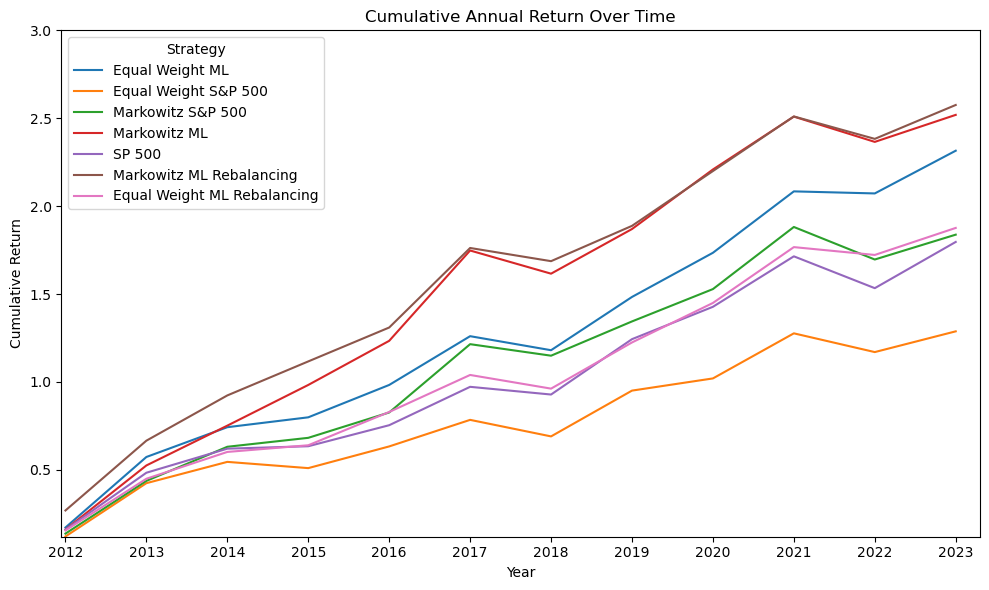

In [234]:
import seaborn as sns

# Create the DataFrame
plots = pd.DataFrame()
plots['year'] = eqweight_ml['year']
plots['Equal Weight ML'] = eqweight_ml['annual return'].cumsum()
plots['Equal Weight S&P 500'] = eqweight_sp500['annual return'].cumsum()
plots['Markowitz S&P 500'] = markowitz_sp500_df['annual return'].cumsum()
plots['Markowitz ML'] = markowitz_ml_df['annual return'].cumsum()
plots['SP 500'] = sp500_returns['annual return'].cumsum()
plots['Markowitz ML Rebalancing'] = annual_return_df['annual return'].cumsum()
plots['Equal Weight ML Rebalancing'] = eqweight_ml_rebal['annual return'].cumsum()

# Melt to long format for seaborn
plots_melted = plots.melt(id_vars='year', var_name='Strategy', value_name='Cumulative Return')

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=plots_melted, x='year', y='Cumulative Return', hue='Strategy')

# Set labels and limits
plt.ylabel("Cumulative Return")
plt.xlabel("Year")
plt.title("Cumulative Annual Return Over Time")
plt.ylim(0.12, 3)
plt.xlim(2011.95, 2023.3)
plt.xticks(ticks=np.arange(2012, 2024, 1))
plt.legend(title='Strategy')
plt.tight_layout()
plt.show()

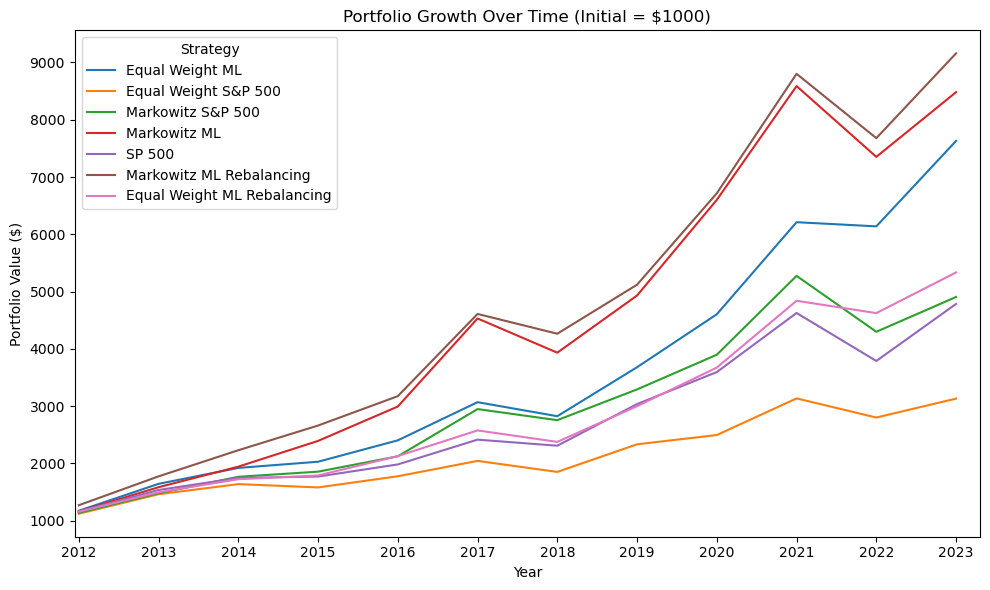

In [235]:
import seaborn as sns

initial_amount = 1000

# Calculate cumulative value (compounded) for each strategy
values = pd.DataFrame()
values['year'] = eqweight_ml['year']
values['Equal Weight ML'] = initial_amount * (1 + eqweight_ml['annual return']).cumprod()
values['Equal Weight S&P 500'] = initial_amount * (1 + eqweight_sp500['annual return']).cumprod()
values['Markowitz S&P 500'] = initial_amount * (1 + markowitz_sp500_df['annual return']).cumprod()
values['Markowitz ML'] = initial_amount * (1 + markowitz_ml_df['annual return']).cumprod()
values['SP 500'] = initial_amount * (1 + sp500_returns['annual return']).cumprod()
values['Markowitz ML Rebalancing'] = initial_amount * (1 + annual_return_df['annual return']).cumprod()
values['Equal Weight ML Rebalancing'] = initial_amount * (1 + eqweight_ml_rebal['annual return']).cumprod()

# Melt to long format
values_melted = values.melt(id_vars='year', var_name='Strategy', value_name='Portfolio Value')

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=values_melted, x='year', y='Portfolio Value', hue='Strategy')

# Labeling and formatting
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Year")
plt.title("Portfolio Growth Over Time (Initial = $1000)")
plt.xticks(ticks=np.arange(2012, 2024, 1))
plt.yticks(ticks=np.arange(1000, 10000, 1000))
plt.xlim(2011.95, 2023.3)
plt.legend(title='Strategy')
plt.tight_layout()
plt.show()

## Feature Analysis

In [236]:
# Assume X is your feature set (DataFrame or array with column names)
keys = list(X)

# Initialize an array to accumulate feature importances
feature_importance_accum = np.zeros(len(keys))

# Loop through model splits and accumulate feature importances
for x in range(1, 13):
    model = models[f'model_split_{x}']
    feature_importance_accum += model.feature_importances_

# Average the importances
feature_importance_avg = feature_importance_accum / 12

# Create the DataFrame
f_imp = pd.DataFrame(data=feature_importance_avg, index=keys, columns=["Gains"]).sort_values(by="Gains", ascending=False)
f_imp["Feature_imp_%"] = (f_imp["Gains"] / f_imp["Gains"].sum()) * 100
f_imp = f_imp.reset_index().rename(columns={'index': 'Feature'})

f_imp

,Feature,Gains,Feature_imp_%
0,garman_klass_volatility,0.136469,13.646871
1,6 month return,0.135445,13.544544
2,beta,0.093337,9.333700
3,current ratio,0.059164,5.916382
4,enterprise value,0.050069,5.006924
5,operating margin,0.048657,4.865689
6,market cap,0.047697,4.769660
7,sales,0.045868,4.586843
8,SMA,0.039604,3.960389
9,earnings yield,0.039445,3.944531


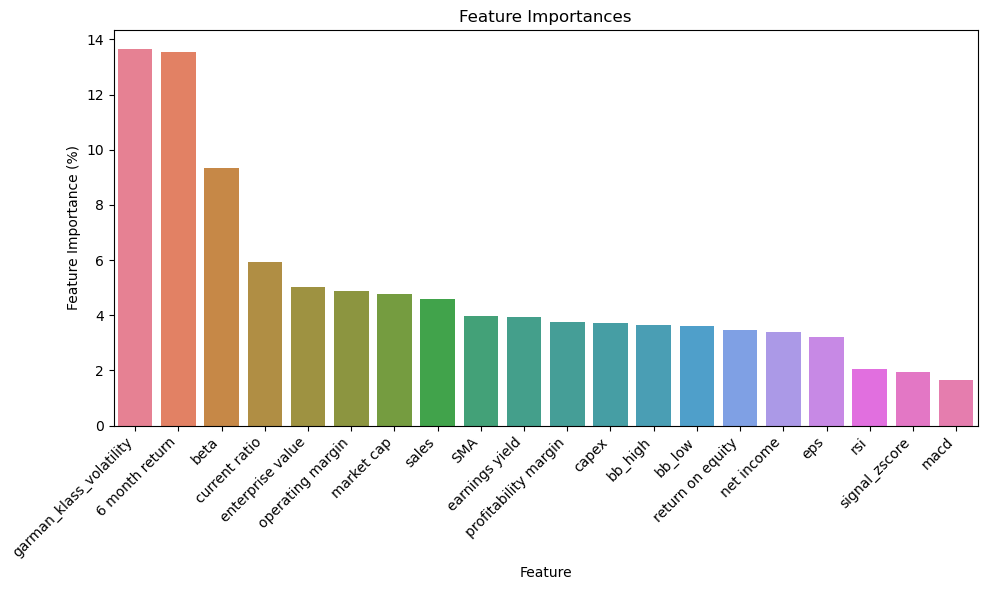

In [237]:
plt.figure(figsize=(10, 6))
sns.barplot(data=f_imp, x='Feature', y='Feature_imp_%', hue='Feature')
plt.xlabel('Feature')
plt.ylabel('Feature Importance (%)')
plt.title('Feature Importances')
plt.xticks(rotation=45, ha='right')  # Rotate labels and align to the right
plt.tight_layout()
plt.show()

In [245]:
# Rename 'annual return' columns in each dataframe for clarity before merging
annual_return_df = annual_return_df.rename(columns={'annual return': 'markowitz_ml_rebal_return'})
markowitz_ml_df = markowitz_ml_df.rename(columns={'annual return': 'markowitz_ml_return'})
markowitz_sp500_df = markowitz_sp500_df.rename(columns={'annual return': 'markowitz_sp500_return'})
eqweight_sp500 = eqweight_sp500.rename(columns={'annual return': 'eqweight_sp500_return'})
eqweight_ml = eqweight_ml.rename(columns={'annual return': 'eqweight_ml_return'})
eqweight_ml_rebal = eqweight_ml_rebal.rename(columns={'annual return': 'eqweight_ml_rebal_return'})
sp500_returns = sp500_returns.rename(columns={'annual return': 'sp500_return'})

# Merge all dataframes on the 'year' column
combined_df = annual_return_df \
    .merge(markowitz_ml_df, on='year', how='outer') \
    .merge(markowitz_sp500_df, on='year', how='outer') \
    .merge(eqweight_sp500, on='year', how='outer') \
    .merge(eqweight_ml, on='year', how='outer') \
    .merge(eqweight_ml_rebal, on='year', how='outer') \
    .merge(sp500_returns, on='year', how='outer')

# Optional: sort by year
combined_df = combined_df.sort_values('year').reset_index(drop=True)
combined_df = combined_df.rename(columns={'year': 'Year'})

In [246]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to apply color scale row-wise
def highlight_extremes(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return ['background-color: lightgreen; color: black' if v else
            'background-color: lightcoral; color: black' if w else
            'background-color: white; color: black'
            for v, w in zip(is_max, is_min)]

# Set 'Year' as index for better row-wise styling
styled_df = combined_df.set_index('Year').style.apply(highlight_extremes, axis=1)

# Display (works in Jupyter environments; to export use .to_html())
styled_df

,markowitz_ml_rebal_return,markowitz_ml_return,markowitz_sp500_return,eqweight_sp500_return,eqweight_ml_return,eqweight_ml_rebal_return,sp500_return
Year,,,,,,,
2012,0.269300,0.161177,0.137762,0.121492,0.172338,0.155596,0.160000
2013,0.397000,0.364145,0.299770,0.303046,0.401146,0.294102,0.323900
2014,0.257300,0.226455,0.194017,0.121136,0.169409,0.152507,0.136900
2015,0.193400,0.231399,0.050861,-0.035529,0.056181,0.037932,0.013800
2016,0.192800,0.250895,0.144227,0.123395,0.184105,0.189350,0.119600
2017,0.452400,0.513781,0.388488,0.151081,0.277362,0.210513,0.218300
2018,-0.075000,-0.131800,-0.065524,-0.094057,-0.079805,-0.077729,-0.043800
2019,0.200800,0.253819,0.194806,0.260433,0.302940,0.262578,0.314900
2020,0.311700,0.338756,0.183991,0.069297,0.251199,0.224707,0.184000


In [248]:
combined_df['markowitz_ml_rebal_return'].mean() - combined_df['sp500_return'].mean()

0.06491666666666665

In [250]:
print(combined_df['markowitz_ml_rebal_return'].mean())
print(combined_df['sp500_return'].mean())

0.21462499999999998
0.14970833333333333


In [251]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.inspection import permutation_importance

In [ ]:
# Drop rows with NaN values from X
X_clean = X.dropna()  # Drop rows with missing values

# List of variables to generate PDPs for
variables = ['garman_klass_volatility', 'rsi', 'bb_low', 'SMA', 'bb_high', 'beta',
             'macd', 'signal_zscore', '6 month return', 'eps', 'net income', 'sales',
             'capex', 'market cap', 'earnings yield', 'operating margin',
             'return on equity', 'profitability margin', 'enterprise value',
             'current ratio']

# Prepare the plot
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 20))
axes = axes.ravel()  # Flatten the axes array for easier iteration

# Loop through each variable and generate the PDP plot
for idx, var in enumerate(variables):
    pdp_result = partial_dependence(
        models['model_split_12'],
        X_clean,
        features=[X_clean.columns.get_loc(var)],  # Get the index of the variable
        percentiles=(0, 1),
        grid_resolution=50,
        kind='average'
    )
    
    # Plot the partial dependence
    ax = axes[idx]
    ax.plot(pdp_result['grid_values'][0], pdp_result['average'][0])
    ax.set_title(var)
    ax.set_ylabel('Partial Dependence')

# Adjust the layout to ensure everything fits
plt.tight_layout()  # No additional padding or rotation needed
plt.show()